To learn more about accelerating pandas on Colab, see the <a href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb">10-minute guide</a> or
 <a href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb">US stock market data analysis demo</a>.

In [4]:

from google.colab import files
uploaded = files.upload()


import zipfile
import os

zip_path = next(iter(uploaded))
extract_dir = "/content/East_masked"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


for i, folder in enumerate(os.listdir(extract_dir)):
    if i >= 5: break
    print(f"{folder}: {os.listdir(os.path.join(extract_dir, folder))}")


Saving East_masked (1).zip to East_masked (1).zip
51_756435173206576, 14_32848486764519_json: ['label_names.txt', 'label.png', 'img.png', 'label_viz.png']
img1_json: ['label_names.txt', 'label.png', 'img.png', 'label_viz.png']
50_59110090410117, 12_70162969096366_json: ['label_names.txt', 'label.png', 'img.png', 'label_viz.png']
51_76208198275501, 14_372938202924061_json: ['label_names.txt', 'label.png', 'img.png', 'label_viz.png']
50_37878405287796, 12_058953017285889_json: ['label_names.txt', 'label.png', 'img.png', 'label_viz.png']


In [5]:

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class RoofDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.folders = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                        if os.path.isdir(os.path.join(root_dir, f)) and
                        os.path.exists(os.path.join(root_dir, f, "img.png")) and
                        os.path.exists(os.path.join(root_dir, f, "label.png"))]
        self.transform = transform

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder = self.folders[idx]
        image = Image.open(os.path.join(folder, "img.png")).convert("RGB")
        mask = Image.open(os.path.join(folder, "label.png")).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()  # Binary mask
        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = RoofDataset(extract_dir, transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        self.down1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.middle = conv_block(128, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.upconv2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.upconv1 = conv_block(128, 64)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        mid = self.middle(p2)
        u2 = self.up2(mid)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.upconv2(u2)
        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.upconv1(u1)
        return torch.sigmoid(self.out(u1))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        preds = model(images)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")


Epoch 1/5, Loss: 15.7530
Epoch 2/5, Loss: 14.8878
Epoch 3/5, Loss: 13.7547
Epoch 4/5, Loss: 12.8140
Epoch 5/5, Loss: 11.8346


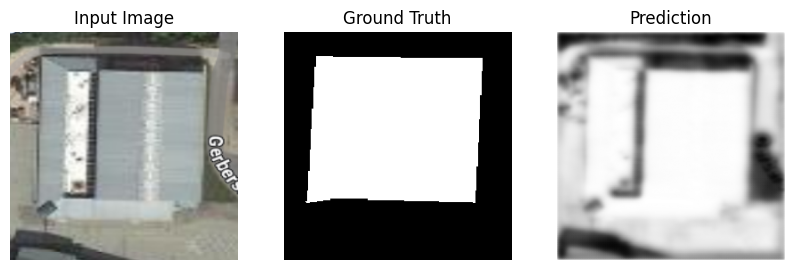

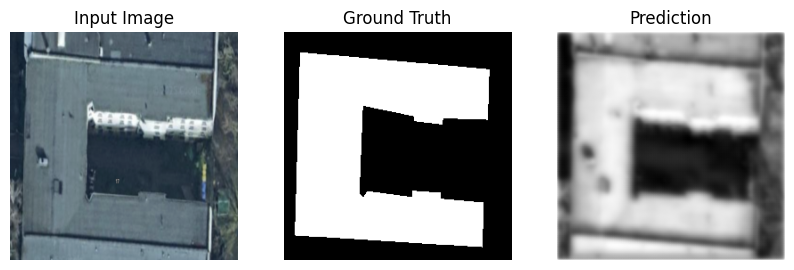

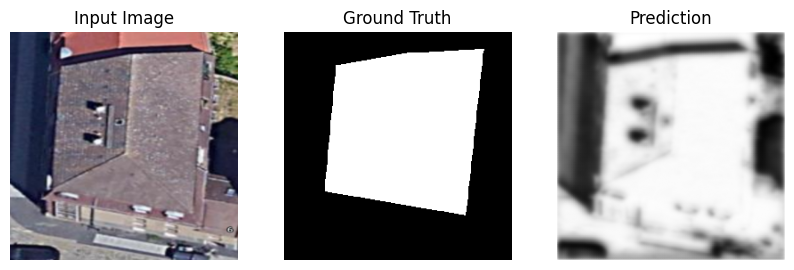

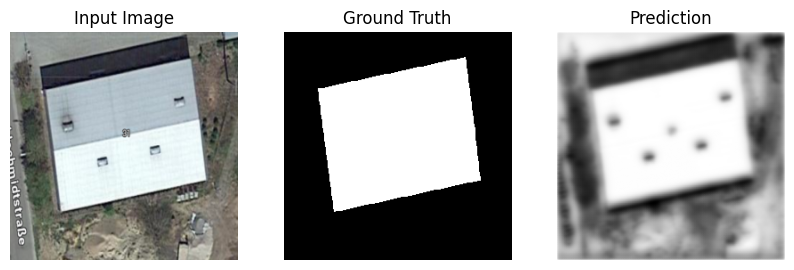

In [6]:
# Showing predictions
model.eval()
with torch.no_grad():
    images, masks = next(iter(loader))
    images = images.to(device)
    preds = model(images)

import matplotlib.pyplot as plt

for i in range(4):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(images[i].cpu().permute(1,2,0))
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(preds[i].cpu().squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.show()
